<a href="https://colab.research.google.com/github/Debottam/MachinLearningEx/blob/master/LSHashAnomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Using TensorFlow backend.


In [0]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [0]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [5]:
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [6]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [7]:
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [8]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [0]:
x_train_bkg = x_train[np.where((y_train!=4)&(y_train!=5)&(y_train!=6))]

In [11]:
x_train_bkg.shape

(42819, 784)

In [0]:
from sklearn.model_selection import train_test_split
x_train_bkg,valid_x_train_bkg = train_test_split(x_train_bkg,
                                                 test_size=0.2, 
                                                 random_state=13)

In [13]:
autoencoder_train = autoencoder.fit(x_train_bkg, x_train_bkg,
                                epochs=50,
                                batch_size=256,
                                shuffle=True,
                                validation_data=(valid_x_train_bkg, valid_x_train_bkg))




Train on 34255 samples, validate on 8564 samples
Epoch 1/50





34255/34255 [==============================] - 1s 41us/step - loss: 0.0692 - val_loss: 0.0421
Epoch 2/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0342 - val_loss: 0.0285
Epoch 3/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0253 - val_loss: 0.0228
Epoch 4/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0209 - val_loss: 0.0195
Epoch 5/50
34255/34255 [==============================] - 1s 26us/step - loss: 0.0183 - val_loss: 0.0174
Epoch 6/50
34255/34255 [==============================] - 1s 26us/step - loss: 0.0165 - val_loss: 0.0160
Epoch 7/50
34255/34255 [==============================] - 1s 26us/step - loss: 0.0153 - val_loss: 0.0149
Epoch 8/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0143 - val_loss: 0.0140
Epoch 9/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0136 - val_loss: 0.013

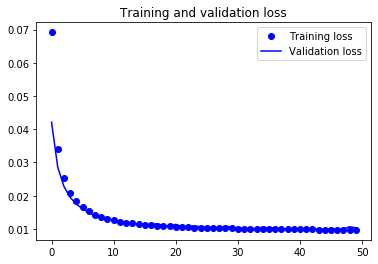

In [14]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
truth = np.zeros(len(y_test))

In [0]:
truth[np.where((y_test==4)|(y_test==5)|(y_test==6))]= 1

In [0]:
predict_nums=autoencoder.predict(x_test)

In [18]:
predict_nums.shape

(10000, 784)

In [0]:
predict_loss_mse= np.mean(np.power(x_test - predict_nums, 2), axis =1)

In [20]:
predict_loss_mse.shape

(10000,)

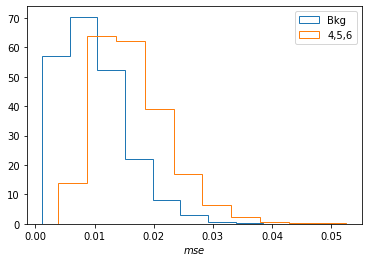

In [22]:

l_rec_0=[]
l_rec_1=[]

for i in range(10000):
    if truth[i]==0:
        l_rec_0.append(predict_loss_mse[i])
    else:
        l_rec_1.append(predict_loss_mse[i])

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)
plt.hist(l_rec_0, histtype="step", label='Bkg', density=True)
plt.hist(l_rec_1, histtype='step', label='4,5,6', density=True)
plt.legend(loc='best')
#plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.xlabel('$mse$')
plt.show()

In [0]:
# Utility function to visualize the outputs of PCA and t-SNE

def num_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [0]:
encoded_test = encoder.predict(x_test)

In [34]:
from sklearn.manifold import TSNE
import time
time_start = time.time()
RS = 123
fashion_tsne = TSNE(random_state=RS).fit_transform(encoded_test)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 92.35051465034485 seconds


In [0]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
import matplotlib.patheffects as PathEffects

(<Figure size 576x576 with 1 Axes>,
 [Text(4.953288, 0.9893092, '0'), Text(-8.945761, -8.62146, '1')])

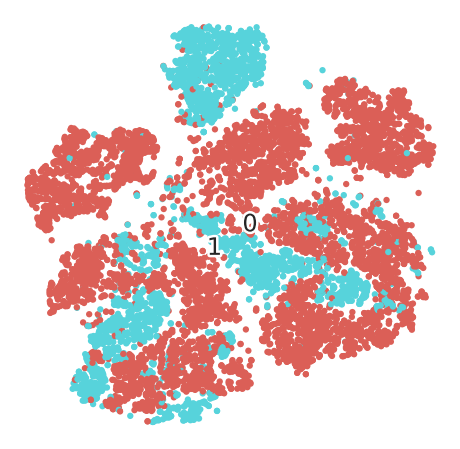

In [38]:
num_scatter(fashion_tsne, truth)